In [1]:
import re
from config import Config
import openai
from openai import OpenAI
from dotenv import load_dotenv
import os
import json
openai.api_key = Config.OPENAI_API_KEY
load_dotenv()  # Load environment variables from .env file
api_key = os.getenv("OPENAI_API_KEY_Ahmed")

In [2]:
import re

# Function to clean and extract JSON from a response
def extract_json(response_text):
    try:
        # Use a regex to find the JSON object within the response
        json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
        if json_match:
            json_str = json_match.group(0)
            return json.loads(json_str)
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", e)
    return None

In [3]:
def clean_response(response):
        response = response.replace("\n", "")
        cleaned_str = re.sub(r"```json|```", "", response)  # Remove backticks and "```json"
        cleaned_str = re.sub(r"\\", "", cleaned_str)  # Remove backslashes
        cleaned_str = re.sub(r"\'", '"', cleaned_str)  # Replace escaped single quotes (\' -> ")
        cleaned_str = re.sub(r'"s ', ' ', cleaned_str)  # Replace "s with space
        cleaned_str = re.sub(r"\s+", " ", cleaned_str)  # Replace multiple spaces with single space
        return cleaned_str.strip()

In [4]:
client = OpenAI(api_key=api_key)
model_name = "gpt-4o"


In [5]:
topic="US-China Trade War"
pers={'Agree': 60, 'Disagree': 40, 'Perspectives': {'1': {'Stance': 'Agree', 'Criteria': ['China ability to sustain economic pressure', 'US aggressive trade tactics alienating allies', 'Potential weakening of USD as global reserve currency'], 'Reason': 'The US will lose the trade war due to China resilience and strategic economic maneuvers.'}, '2': {'Stance': 'Agree', 'Criteria': ['Trump poor execution of trade policies', 'Impact on US domestic industries like bourbon', 'China long-term planning and economic growth'], 'Reason': 'Trump mismanagement has weakened US standing, making it likely to lose the trade war.'}, '3': {'Stance': 'Disagree', 'Criteria': ['US strategic economic levers', 'China vulnerability to export losses', 'Potential US Treasury maneuvers'], 'Reason': 'The US holds a stronger economic position and can mitigate the effects of the trade war.'}, '4': {'Stance': 'Disagree', 'Criteria': ['China economic instability', 'US ability to adapt and innovate', 'China internal economic challenges'], 'Reason': 'China internal economic weaknesses and reliance on exports make it more vulnerable in the trade war.'}}}

In [6]:
perspectives={topic: pers}

In [7]:
perspectives

{'US-China Trade War': {'Agree': 60,
  'Disagree': 40,
  'Perspectives': {'1': {'Stance': 'Agree',
    'Criteria': ['China ability to sustain economic pressure',
     'US aggressive trade tactics alienating allies',
     'Potential weakening of USD as global reserve currency'],
    'Reason': 'The US will lose the trade war due to China resilience and strategic economic maneuvers.'},
   '2': {'Stance': 'Agree',
    'Criteria': ['Trump poor execution of trade policies',
     'Impact on US domestic industries like bourbon',
     'China long-term planning and economic growth'],
    'Reason': 'Trump mismanagement has weakened US standing, making it likely to lose the trade war.'},
   '3': {'Stance': 'Disagree',
    'Criteria': ['US strategic economic levers',
     'China vulnerability to export losses',
     'Potential US Treasury maneuvers'],
    'Reason': 'The US holds a stronger economic position and can mitigate the effects of the trade war.'},
   '4': {'Stance': 'Disagree',
    'Criter

In [8]:
summaries = {}

In [9]:
for topic, perspective_data in perspectives.items():
        prompt = f"""
        Given a statement and a set of perspectives, generate two distinct summaries:

        - One summarizing the perspectives that agree with the statement.
        - One summarizing the perspectives that disagree with the statement.

        Please follow these requirements:
        1. The perspectives within each summary should be non-overlapping.
        2. The summary content should remain closely tied to the original statement.
        3. Format the output in the following JSON structure:

        {{
          "statement": "<original statement>",
          "summaries": {{
            "agree": "<summary based on agreeing perspectives>",
            "disagree": "<summary based on disagreeing perspectives>"
          }}
        }}

        Input:
        Statement: "USA-China in Trade war is unbelievable."
        Perspectives: {json.dumps(perspective_data['Perspectives'], indent=2)}
        """

        try:
            response = client.chat.completions.create(
                model=model_name,
                messages=[
                    {"role": "system", "content": "You are a summarization assistant that considers agreement and disagreement."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.7
            )
            print(response.choices[0].message.content)
            content = response.choices[0].message.content
            cleaned = clean_response(content)
            parsed = json.loads(cleaned)
            summaries[topic] = {
                "agree": parsed["summaries"]["agree"],
                "disagree": parsed["summaries"]["disagree"]
            }
        except Exception as e:
            print(f"Error summarizing perspectives for topic '{topic}': {e}")
            summaries[topic] = {
                "agree": "Error generating agree summary.",
                "disagree": "Error generating disagree summary."
            }

```json
{
  "statement": "USA-China in Trade war is unbelievable.",
  "summaries": {
    "agree": "The US is expected to lose the trade war due to China's resilience, strategic economic maneuvers, and long-term planning. The US's aggressive trade tactics are alienating allies, and Trump's poor execution of trade policies has weakened the US's standing, affecting domestic industries like bourbon.",
    "disagree": "The US is in a stronger position in the trade war due to its strategic economic levers and ability to adapt and innovate. China's vulnerability to export losses, economic instability, and internal challenges make it more susceptible to the negative impacts of the trade war."
  }
}
```


In [10]:
summaries

{'US-China Trade War': {'agree': 'The US is expected to lose the trade war due to China resilience, strategic economic maneuvers, and long-term planning. The US aggressive trade tactics are alienating allies, and Trump poor execution of trade policies has weakened the US standing, affecting domestic industries like bourbon.',
  'disagree': 'The US is in a stronger position in the trade war due to its strategic economic levers and ability to adapt and innovate. China vulnerability to export losses, economic instability, and internal challenges make it more susceptible to the negative impacts of the trade war.'}}

In [1]:
from nltk.tokenize import sent_tokenize

In [2]:
sentences = sent_tokenize("In the realm of global economics, the ongoing trade war between the United States and China represents a seismic conflict with reverberations felt far beyond their respective borders. With each country vying for economic supremacy, the trade war has sparked a myriad of perspectives regarding its potential outcomes and long-term impacts on international relations. Key to this debate are the tactics, strategies, and vulnerabilities each nation brings to the table as they navigate the turbulent waters of tariffs and trade policies.")

In [7]:
sentences.append("Donald Trump is a crooked white supremacist who hates others.")

In [4]:
import torch
from transformers import pipeline
bias_detector = pipeline("text-classification", model="himel7/bias-detector")
bias_type_classifier = pipeline("text-classification", model="maximuspowers/bias-type-classifier")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [11]:
bias_flags = []
for sentence in sentences:
    result = bias_detector(sentence)[0]
    label = result["label"]
    score = result["score"]
    is_biased = label == "LABEL_1"
    bias_flags.append({
        "sentence": sentence,
        "biased": is_biased,
        "score": round(score, 4)
    })

In [12]:
bias_flags

[{'sentence': 'In the realm of global economics, the ongoing trade war between the United States and China represents a seismic conflict with reverberations felt far beyond their respective borders.',
  'biased': True,
  'score': 0.6161},
 {'sentence': 'With each country vying for economic supremacy, the trade war has sparked a myriad of perspectives regarding its potential outcomes and long-term impacts on international relations.',
  'biased': False,
  'score': 0.7598},
 {'sentence': 'Key to this debate are the tactics, strategies, and vulnerabilities each nation brings to the table as they navigate the turbulent waters of tariffs and trade policies.',
  'biased': False,
  'score': 0.6409},
 {'sentence': 'Donald Trump is a crooked white supremacist who hates others.',
  'biased': True,
  'score': 0.9931}]

In [13]:
biased_sentences=["In the realm of global economics, the ongoing trade war between the United States and China represents a seismic conflict with reverberations felt far beyond their respective borders.","Donald Trump is a crooked white supremacist who hates others."]

In [14]:
bias_types = []
for sentence in biased_sentences:
    result = bias_type_classifier(sentence)[0]
    bias_types.append({
        "sentence": sentence,
        "bias_type": result["label"],
        "score": round(result["score"], 4)
    })

In [15]:
bias_types

[{'sentence': 'In the realm of global economics, the ongoing trade war between the United States and China represents a seismic conflict with reverberations felt far beyond their respective borders.',
  'bias_type': 'nationality',
  'score': 0.984},
 {'sentence': 'Donald Trump is a crooked white supremacist who hates others.',
  'bias_type': 'political',
  'score': 0.9125}]

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [4]:
neutralizer_model_name = "himel7/bias-neutralizer-t5s"
neutralizer_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
neutralizer_tokenizer = AutoTokenizer.from_pretrained(neutralizer_model_name)
neutralizer_model = AutoModelForSeq2SeqLM.from_pretrained(neutralizer_model_name)
neutralizer_model.to(neutralizer_device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [20]:
def neutralize_bias(sentence):
    input_text = "neutralize: " + sentence
    inputs = neutralizer_tokenizer(input_text, return_tensors="pt", truncation=True, padding=True).to(neutralizer_device)
    output_ids = neutralizer_model.generate(**inputs, max_length=128, num_beams=4)
    return neutralizer_tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [58]:
sent1="**The Erosion of USD Hegemony**
One of the most significant risks highlighted by experts is the potential erosion of U.S. Dollar (USD) hegemony."

In [59]:
sent=neutralize_bias(sent1)

In [60]:
sent2=sent.capitalize()

In [61]:
sent2

' **the erosion of usd hegemony**'

In [55]:
sent2.strip().lower()

'**the erosion of usd hegemony** one of the most significant risks highlighted by experts is the erosion of u.s. dollar (usd) hegemony.'

In [56]:
sent1.strip().lower()

'**the erosion of usd hegemony** one of the most significant risks highlighted by experts is the potential erosion of u.s. dollar (usd) hegemony.'

In [54]:
if sent2.strip().lower() == sent1.strip().lower():
            print(f"[Fallback] Using GPT for: {sent1}")

In [47]:
from openai import OpenAI
from dotenv import load_dotenv
import os
load_dotenv()  # Load environment variables from .env file
api_key = os.getenv("OPENAI_API_KEY_Ahmed")
client = OpenAI(api_key=api_key)
model_name = "gpt-4o"
def neutralize_with_gpt(sentence):
    prompt = (
        f"The following sentence contains biased language:\n\n"
        f"{sentence}\n\n"
        f"Rewrite it in a neutral and objective tone."
    )

    response = client.chat.completions.create(
        model=model_name,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
    )

    return response.choices[0].message.content.strip()

In [48]:
n=neutralize_with_gpt(sent1)

In [49]:
n

'The role of religious beliefs in scientific discussions is a topic of diverse perspectives and can vary depending on the context.'

In [62]:
article= "**The Complex Web of US-China Relations: Navigating a New Era of Economic and Geopolitical Challenges**\n\nIn the intricate tapestry of international relations, the dynamic between the United States and China stands as one of the most pivotal."

In [71]:
import re
from nltk.tokenize import sent_tokenize

def custom_split_article(article):
    lines = article.split('\n')
    result = []
    buffer = ""

    for line in lines:
        stripped = line.strip()

        # Detect and preserve markdown headers
        if re.match(r'^#+\s', stripped) or re.match(r'^\*\*.*\*\*$', stripped):
            # First flush the buffer as normal text
            if buffer:
                result.extend(sent_tokenize(buffer.strip()))
                buffer = ""

            # Preserve heading with double newline
            result.append(stripped + "\n\n")
            continue

        # Collect regular content
        if stripped:
            buffer += ' ' + stripped

    # Final flush of remaining buffered text
    if buffer:
        result.extend(sent_tokenize(buffer.strip()))

    return result


In [72]:
sentences = custom_split_article(article)

In [66]:
allsentences = sent_tokenize(article)

In [67]:
allsentences

['**The Complex Web of US-China Relations: Navigating a New Era of Economic and Geopolitical Challenges**\n\nIn the intricate tapestry of international relations, the dynamic between the United States and China stands as one of the most pivotal.']

In [73]:
sentences

['**The Complex Web of US-China Relations: Navigating a New Era of Economic and Geopolitical Challenges**\n\n',
 'In the intricate tapestry of international relations, the dynamic between the United States and China stands as one of the most pivotal.']

### Echo Chamber

In [77]:
original_text="""Doodsonious22: What happens if we lose the trade war?
littlestickarm: If this happens we will lose our main export, USD. We would see quite an uptick in inflation domestically.
Beard_fleas: Everyone loses in a trade war. There is no winning. 
None: It's important to remember that the US declared a trade war on almost every country in the world. 

Everyone else is engaged in a trade war with one country, albeit a very big one.  The other countries can work around us.  The US is working against multiple fronts.  

Had Trump resolved his issues with our allies and then moved on to China we may have come out better off since China has gamed trade agreements in many ways.

Conducting a trade war with all our major allies and China at the same time is a terrible fucking strategy.
BoogerSugarSovereign: Everyone loses in trade wars. This will damage the US' trade relationships which will reduce trade opportunities which will reduce growth opportunities. The only question is what the extent of the damage will be. 
Qualityhams: Having a trade war IS losing the trade war.
ergonomic_logic: Trump is bad for the economy, unstable, unreliable, unprofessional.

The sooner everyone gets on that same page so we can come to a consensus on what's to be done and how to handle damage control and cleanup, the better.

The problem is we can't all agree on something even when our livelihoods bank on it.

We've already lost the trade war in many ways and reputationally other countries see the US as seriously unstable right now and even if we were able to get an adult in power, trying to clean up this mess is nigh impossible now.
L44KSO: There are no winners in trade wars.
Boys4Ever: In the end China and other markets still need our demand and reason trade deficits exist. We are just wealthier per capita and exercise zero caution when it comes to wants. However, fair to assume much of that sold here gets redirected elsewhere to decouple dependency on USA. Should that happen then cost of living just went up for us. Less supply with no curve in demand and possibly fired Fed Powell resulting in zero rates and new printed money could take a decade to unwind. Biggest concern is if the ROW has lost confidence in We the People to elect the best people.
ziggy029: Pretty much everyone loses in a trade war.  The vast majority of liberal AND conservative economists agree on that one.  Some may lose more than others, though.
Jack_Riley555: If? We already have.
Thomas_Mickel: A laptop will cost $2500. 

Eggs will be $12. 

And you will need 2 jobs to rent a room for $2000/month.
720pothead: We are a nation of consumers...we rely on outside goods. Most Americans don't even have enough money for their own regular lifestyle (hence the credit card debt), now imagine higher costs
StepAsideJunior: ***TLDR;***

It would be the end of US Dollar Hegemony. Trade wars particularly tariffs are often precursors to much bigger wars in modern history. The US can't risk losing dollar hegemony.

It can't win in a true trade war against China, however, the U.S. still has a massive military advantage over China that will only last a few more years at best.

Remember that China does not need to develop a military that's equal to the U.S. military, it just needs to build up a military force capable of defeating the U.S. in the South China Sea. The time window for that gets smaller and smaller each year.

Unfortunately, for US policy planners this is the only chance the US has to fix the playing field in its favor.

This trade war is just the opening salvo, if this administration is serious it will continue escalating until we are at all out war with China (including the use of nukes).

**Long:**

A trade war is often the beginning salvos of a bigger war. Nearly all of the worst conflicts in Modern History from the Opium Wars to WW2 started with a trade war and with tariffs in particular.

Most people outside America know that Trump doesn't actually control the country and that real policies don't actually change from one administration to the next (no country in the world would actually function if that were the case).

The US has to escalate against China because what's at stake for US oligarchs is a collapse of the current System that has allowed them to become the richest people in human history.

Dollar Hegemony means only the US can print money and that all countries in the world are forced to buy dollars from the US if they want to purchase precious resources like oil, gas, precious metals, semiconductors, etc. 

Dollar hegemony makes the US an inflation proof country.

As an example, it took China nearly 20 years to accumulate 3 trillion US dollars via exports. Meanwhile, in a couple years the US just printed 17 trillion dollars. In most countries printing that much money would lead to quadruple, quintuple, or even sextuple digit levels of inflation, in the US it barely led to a double digit rises (and even that small rise drastically hurt the American consumer).

Why?

Because other countries saw the value of their dollar decrease due to the US pumping out more dollars, so in response those countries are ***FORCED*** to purchase more US dollars which in effect stabilizes the dollar. Remember oil and gas ***HAVE*** to be purchased in dollars.

Why?

Because the US effectively controls every single Middle Eastern Oil producing nation (with the exception of Iran; hence all the saber rattling). Those countries will 90%+ of the time only accept dollars for their oil and gas due to the US holding a literal gun to their heads.

How?

Through countries like Israel (that serve as unsinkable aircraft carriers for the US) and by maintaining carrier fleets, military bases, and hundreds of thousands of soldiers in the most geo strategic region in the history of the world.

Basically, the US if it wants to maintain the uniquely powerful position its had since the 1980's has to escalate against China. If the Trade War fails, then a military option is 100% on the table. God help us all.
lemongrenade: lol im not sure but i think we are gonna find out
highfalutinnot:  Trade war is not a win or lose game, it's a lose and lose more game.  Everyone loses. In this case, when godzilla and Kong are going at it, everyone else gets taken out as collateral damage.
 DrThomasBuro: Trump’s trade war is about to change the way you shop
AutoModerator: Hi all,

A reminder that comments do need to be on-topic and engage with the article past the headline. Please make sure to read the article before commenting.  Very short comments will automatically be removed by automod. Please avoid making comments that do not focus on the economic content or whose primary thesis rests on personal anecdotes. 

As always our comment rules can be found [here](https://reddit.com/r/Economics/comments/fx9crj/rules_roundtable_redux_rule_vi_and_offtopic/)

*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/Economics) if you have any questions or concerns.*
Snapingbolts: And remember this was completely avoidable and will most likely leave the US in a worse position trade wise going forward. I've never seen a president do something so reckless and stupid with no tangible benefit to the country.
DrThomasBuro: Quote You’re about to feel the effects of President Donald Trump’s trade war every time you shop.

In a matter of weeks, infinite varieties, colors, sizes and flavors will be replaced with smaller selections, fewer options and limited choice. It will represent a stark change from what consumers have been accustomed to at stores and online.
Separate-Analysis194: Interesting how no mention of sourcing products from US, instead the tariffs are just diverting suppliers from China to Vietnam / Cambodia. So no new US jobs but consumers pay higher prices and have less choice. Great policy!
Tremenda-Carucha: It's just incredibly depressing how these tariffs are squeezing the choices available to regular folks, and, you know, while it's nice to hear some companies are trying to find new suppliers, that's something, I suppose, the bigger worry is what this all means for the overall economy, especially considering how much we previously benefited from free trade, I'm really curious about whether this trade war will reshape our standing on the world stage, leaving us weaker and with fewer options, and honestly, the possibility of lasting economic consequences keeps me up at night, thinking about the future.
Toolatethehero3: I don’t want to be on this roller coaster but there is a certain fascination with watching the Trump supporters grabble with the reality of Trumps destruction. It will start with groceries and daily bills which will rocket in cost, then the empty shelves, then the collapsing stock market and lost 401k and then the job losses. I have no doubt that Trump will blame Biden and ‘other countries attacking us’ forgetting entirely Trump’s role in destroying every alliance we have, insulting every friend and then waging war on them all.
Aloyonsus: Tariffs are just a way to increase taxes on the working class to help pay for the ruling class tax cuts without MAGA understanding what’s going on.  He peppers them with misinformation to make it sound like he has their interests in mind (eliminating income tax, taxing millionaires) but it’s all about what he does and not how he markets the increased tax collection on working class Americans.
Horror-Layer-8178: Jokes on them I just bought most of things I planned to buy for a year. I made all my electronic purchases, switched to a bidet bought the Costco paper towels batteries and batteries. I wonder how many people did what I did and everyone cutting back will be enough to cause an economic downturn
Successful_panhandlr: Listen. My job switched to US manufacturers to handle things like getting uniforms made, and actual product assembly. The switch itself was bad, but to top it off, none of the new supplies for new uniforms has shown up and they were ordered 3 months ago. And since production switched to US production, instead of overseas production. The quality of the products we sell and service have declined by a lot. We're a huge, global company and people at high places within it are worried the switch may cause catastrophic consequences with its US branch of operations. 

And this is happening to a company that didn't have to start from the ground up here in America and has been doing business here since 1955. 

So in short, trumps policies are so bad that it's affecting world wide companies abilities to operate

People elected a rapist and criminal into office and now we're all being Fucked
artisanrox: It already has. I overbought a bit on appliances and supplies and unfortunately I think it'll be worth it.

Soooooo many YOLOs around me that are not going to be ready for any of this. 

 :(
NeurodivergentNerd: Take a breath, people. The checks haven't even started to bounce from the first wave of people cut back in January. Everything is about to change in America, and we have no way to predict how.
redrocketredglare: Yea, I have to find the thing out in the wild and not go straight to the internet. Forget about price checking cause that will be screwed too. Every business needs to add the cost of tariffs on all transactions. Art of the deal my ass.
tjc4: I wonder if the people who put all the Biden "I did that" stickers on the gas pumps are going to go around grocery and department stores doing the same thing with Trump stickers.
RedditReader4031: Even if he suddenly comes to his senses or the next administration starts repairing what he broke, prices will never recover. Retailers will have succored how high they can push prices before customers pull back.
rileyAutomatic: I work for a distributor that supplies tools in the telecommunications industry. Every other day we’re getting updated price lists from one of our many manufacturers. The general feeling is icky but many of our customers are now relying on the broadband act out into place by Biden. I don’t think that’ll have time to trickle down.
 StupidMoron1933: What is the new trade war threshold?
dagli68: No the threshold is the same. But now defunding military gives 3 budget while funding healthcare costs 2. So before the update if you defunded military but funded rest it cost 7 budget. Now it costs 5. If you dont wanna defund military and fund everything than you better play free market and privatize the shit out of everything.
Soletata67r: They changed the cost of funding and defunding ministries
 yvonne1312: As predicted, China won the trade war
AutoModerator: [COME SHITPOST WITH US ON DISCORD!](https://discord.gg/D84wjqK5J5)

[SUBSCRIBE ON YOUTUBE](https://www.youtube.com/@thedeprogram9999/)

[SUPPORT THE BOYS ON PATREON](https://www.patreon.com/TheDeprogram)

*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/TheDeprogram) if you have any questions or concerns.*
None: Fart of the Eel 🤡

https://preview.redd.it/mdc23l9yoiwe1.jpeg?width=1170&format=pjpg&auto=webp&s=05a3c2834da07c6e1d52a4fa98caa0917805649a
None: A stupid and pointless trade war, because Trump is too stupid to understand a global trading system that benefits America more than anyone else.

The damage is done. Even allies like Europe, Canada and Mexico will be looking to be less dependent on the US going forward. Trump is a uniquely stupid person and the same goes for his voters.
Legitimate_Gold_6161: https://preview.redd.it/hjb1hfhexiwe1.png?width=1166&format=png&auto=webp&s=86bf6f24082019da6b9724e2ee281064269ba031
GrafZeppeln: nahhh I thought it had been a month but it wasn't even lmfao
AppalachanKommie: You love to see China finally revealing their hard earned muscular body after hiding it with extra big shirts and jackets to hide their form.
SlowFadingSoul: Do nothing. Win. 
HanWsh: https://preview.redd.it/69l6sfcvviwe1.png?width=1043&format=png&auto=webp&s=874efe75383b16a4eeffe5646dcd7c29d4d5c87c
timtomorkevin: Dear China: Finish them
ProSovietist: I hope that china doesnt Let go its tarrifs on the US, because the US needs china this much while china doesnt seem to need the US as much.
Critstop: The comments hard coping though
Lydialmao22: Was it really a war? What did China even do in retaliation?
simplefunction: No, comrade premier. It's only begun
Radiant_Ad_1851: Honestly now I'm just confused as to what the administration plans are. They can't seem to make up their mind about anything. Although I suppose if they don't know what they're doing it's impossible for us to predict them either
Ok-Albatross899: Masterful gambit sir
 Oldhamii: Trump ‘Misjudged’ China on Trade War
UniqueSteve: I’m no expert, but I feel like China has a 100 year plan and the US doesn’t plan past the next election — ever. And now with this disgrace in office, they don’t have a plan that goes out more than a day. 

That is of course, unless the plan is to destroy the country, crash the world economy and hand leadership over to China and Russia on every front — in which case no notes, they are knocking it our off the park.
Queasy-Protection-50: Yes because Donald Trump is an utter moron who hasn’t actually run his business in decades
MyUserLame: The Mar-a-lago Accord simply assumed everyone would just roll over on tariffs.  Countries calling our bluff was never considered because our country is being run by a bunch of imbeciles.
MethylphenidateMan: "Misjudge" implies that he's capable of evaluating complex phenomena by weighting their components against each other to determine how to factor them into his strategy, but made a mistake in that process. If that was the case, we could sleep way better.  
The correct headline would be "Trump discovers a new thing he can't make happen just by wildly running his mouth".
Spire_Citron: This is one of the many ways that bigotry makes you weak. They were only able to see China through their own distorted lens, so they were completely unprepared for reality.
silverport: U.S. tends to “misjudge” everything outside its borders. It misjudged Vietnam, Korea, Iraq, Afghanistan etc…
EKcore: China has been spending the last 15 years spending all their money buying soft power all over the world. Via infrastructure investments. America has been bombing everywhere as their soft power. 


The Chinese market is secure, they managed to uplift Africa and South America to not rely on the US.
ChrisPollock6: Do you mean the ranting and screaming of this petulant, over-indulged toddler isn’t working…shocking!
Cold-Environment-634: Stephen Miran’s plan assumed China wouldn’t stonewall us. It all fell apart immediately.
adrr: Country that planned for a full embargo in their Taiwan invasion plan not affected by Tariffs.   I am shocked.
CoquitlamFalcons: Like Putin thought his Russian Army would have triumphantly marched into Kiev back in 2022?
FaleBure: Yeah no shit. He's even more stupid than what was obvious to the rest of the world before this. Evil we learned with Canada and Greenland, cruel we see with Ukraine, bought with Elon and trained by Russia, but this is just plain stupid.
SirPoopaLotTheThird: He’s an incredibly dimwitted person. It’s unbelievable anyone ever supported this moron.
Sun_Tzu_7: There was a way that this could have worked where the US would have still had tremendous leverage.

That stopped when the rate got close to 100%

Anything over 100% is cutting off trade.

If China completely cuts off trade with the US it will definitely hurt them economically but life for their people will stay more or less the same in 4 months.

If the US completely cuts off trade with China, it will send the economy into a deathloop because half the shelves in the stores will be empty. Prices will go through the roof. People will freakout and panic. And China knows this.

A big part of the economy is psychological. People see empty shelves, they start hoarding and there's even less available.

People panic because first prices went up and now they can't even find what they need anymore.

Companies can't sell what they don't have.

People spending less combined with businesses not being able to sell anything has a compounding effect.
hanky0898: Trump gets his advice on China from Navarro /Ron varra and Gordon Chang Who both know nothing about China.
"""

In [82]:
allTopics= {'Dollar Hegemony and Global Currency': 15, 'Economic Impact on the US': 25, 'Impact on Global Trade and Alliances': 20, 'Political and Strategic Implications': 10, 'US-China Trade War': 30}

In [119]:
import networkx as nx
import community as community_louvain
from collections import defaultdict
from transformers import pipeline
import re

In [88]:
def extract_user_comments(text):
    """Parses lines like 'Username: comment' into a dict."""
    lines = text.split("\n")
    pattern = re.compile(r"^([^\s:]{2,40}):\s*(.*)")
    comments = defaultdict(str)
    current_user = None

    for line in lines:
        match = pattern.match(line.strip())
        if match:
            current_user = match.group(1)
            comments[current_user] += match.group(2) + " "
        elif current_user:
            comments[current_user] += line.strip() + " "
    return dict(comments)

In [89]:
# Step 1: Parse user-comment mapping
user_comments = extract_user_comments(original_text)

In [90]:
user_comments

{'Doodsonious22': 'What happens if we lose the trade war? ',
 'littlestickarm': 'If this happens we will lose our main export, USD. We would see quite an uptick in inflation domestically. ',
 'Beard_fleas': 'Everyone loses in a trade war. There is no winning. ',
 'None': "It's important to remember that the US declared a trade war on almost every country in the world.  Everyone else is engaged in a trade war with one country, albeit a very big one.  The other countries can work around us.  The US is working against multiple fronts.  Had Trump resolved his issues with our allies and then moved on to China we may have come out better off since China has gamed trade agreements in many ways.  Conducting a trade war with all our major allies and China at the same time is a terrible fucking strategy. Fart of the Eel 🤡  A stupid and pointless trade war, because Trump is too stupid to understand a global trading system that benefits America more than anyone else.  The damage is done. Even alli

In [92]:
# Step 2: Build a basic adjacency graph
G = nx.Graph()
users = list(user_comments.keys())
for i in range(len(users) - 1):
    u1, u2 = users[i], users[i + 1]
    G.add_edge(u1, u2)

In [142]:
#sentiment = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", top_k=None)
sentiment = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", top_k=None)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [143]:
text[:512]

"Trump gets his advice on China from Navarro /Ron varra and Gordon Chang Who both know nothing about China.   Yeah no shit. He's even more stupid than what was obvious to the rest of the world before this. Evil we learned with Canada and Greenland, cruel we see with Ukraine, bought with Elon and trained by Russia, but this is just plain stupid.  There was a way that this could have worked where the US would have still had tremendous leverage.  That stopped when the rate got close to 100%  Anything over 100% "

In [144]:
s=[]
s = sentiment(text[:512])[0]

In [145]:
s

[{'label': 'negative', 'score': 0.8479071855545044},
 {'label': 'neutral', 'score': 0.13820350170135498},
 {'label': 'positive', 'score': 0.01388928759843111}]

In [146]:
user_sentiments = {}
for user, text in user_comments.items():
    #print("Input Text: ",text)
    s = sentiment(text[:512])[0]
    label = s[0]["label"]
    score = s[0]["score"]
    #print("Sentiment: ",label)
    user_sentiments[user] = {
        "positive": score,
        "neutral": 0.0,
        "negative": -score
    }.get(label, 0.0)

In [148]:
# Step 4: Update edge weights by sentiment similarity
for u, v in G.edges():
    sim = 1 - abs(user_sentiments.get(u, 0) - user_sentiments.get(v, 0))
    G[u][v]["weight"] = round(sim, 3)

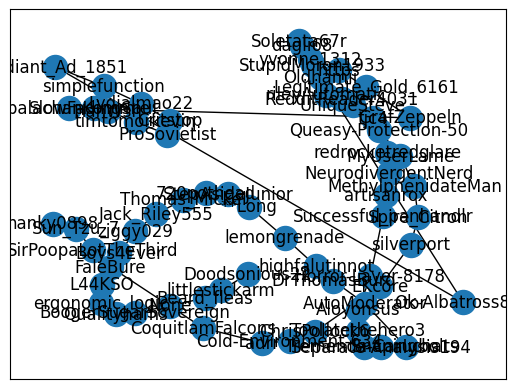

In [150]:
nx.draw_networkx(G)

In [157]:
from networkx.algorithms import community
# Using Louvain algorithm from NetworkX
partition = community.louvain_communities(G, weight="weight", seed=42)

In [158]:
# Convert to the same format as python-louvain (node: community_id dict)
partition_dict = {}
for i, community_set in enumerate(partition):
    for node in community_set:
        partition_dict[node] = i

In [160]:
# Step 6: Format output
nodes = [{"id": node, "community": partition_dict[node]} for node in G.nodes()]
links = [{"source": u, "target": v, "value": G[u][v]["weight"]} for u, v in G.edges()]

In [159]:
print(f"Found {len(partition)} communities")
print(f"Community sizes: {[len(comm) for comm in partition]}")

Found 13 communities
Community sizes: [3, 5, 7, 5, 5, 4, 5, 5, 9, 1, 8, 4, 4]


/var/folders/4j/lfyylb311zz43rwm57kmmfpw0000gn/T/ipykernel_78852/704076027.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


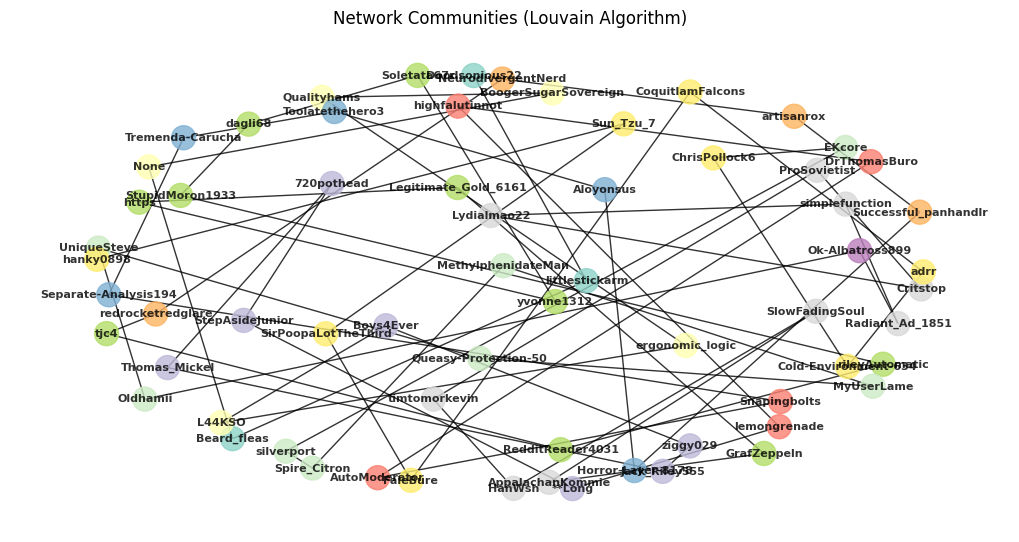

In [155]:
#%% Method 1: Basic community visualization with colors
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))

# Create a color map for communities
num_communities = len(partition)
colors = plt.cm.Set3(np.linspace(0, 1, num_communities))

# Create node colors based on community membership
node_colors = [colors[partition_dict[node]] for node in G.nodes()]

# Draw the graph
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)
nx.draw(G, pos, 
        node_color=node_colors,
        node_size=300,
        with_labels=True,
        font_size=8,
        font_weight='bold',
        alpha=0.8)

plt.title("Network Communities (Louvain Algorithm)")
plt.axis('off')
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


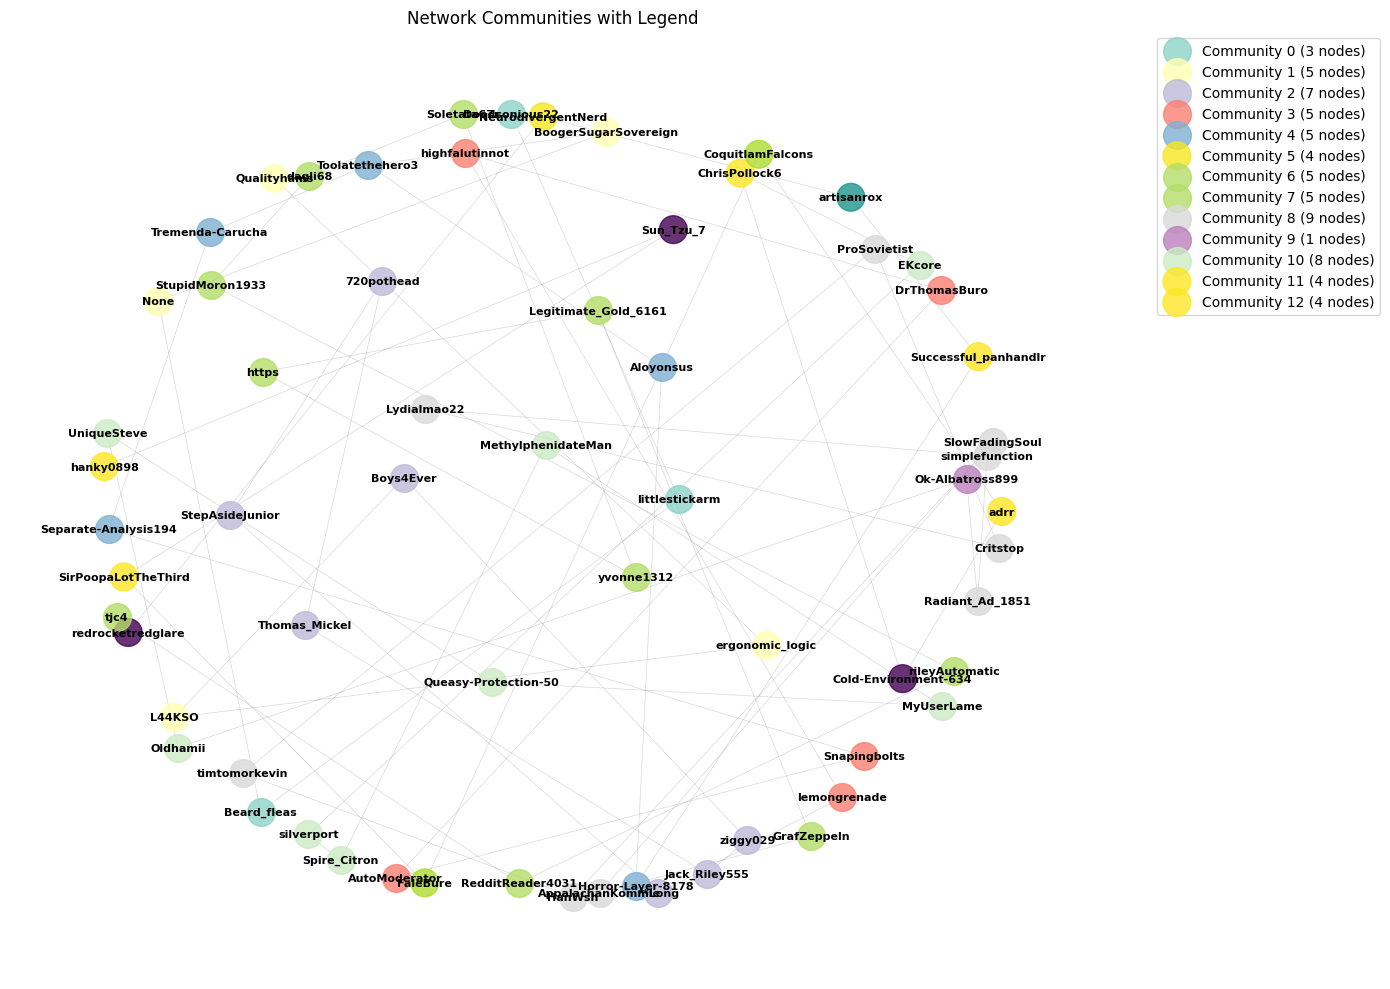

In [156]:
#%% Method 2: Enhanced visualization with community labels
plt.figure(figsize=(14, 10))

# Use different layout algorithms for better separation
pos = nx.spring_layout(G, k=2, iterations=100, seed=42)
# Alternative layouts to try:
# pos = nx.kamada_kawai_layout(G)
# pos = nx.fruchterman_reingold_layout(G, k=2, iterations=100)

# Draw edges first
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5, edge_color='gray')

# Draw nodes colored by community
for i, community_set in enumerate(partition):
    node_list = list(community_set)
    nx.draw_networkx_nodes(G, pos,
                          nodelist=node_list,
                          node_color=colors[i],
                          node_size=400,
                          alpha=0.8,
                          label=f'Community {i} ({len(node_list)} nodes)')

# Add labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title("Network Communities with Legend")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('off')
plt.tight_layout()
plt.show()

In [161]:
from collections import defaultdict

community_texts = defaultdict(str)
for user, comm_id in partition_dict.items():
    community_texts[comm_id] += user_comments[user] + " "


In [162]:
from keybert import KeyBERT
kw_model = KeyBERT()

community_keywords = {}
for comm_id, text in community_texts.items():
    keywords = kw_model.extract_keywords(text, top_n=5)
    community_keywords[comm_id] = [kw[0] for kw in keywords]


In [163]:
community_keywords

{0: ['inflation', 'war', 'usd', 'loses', 'export'],
 1: ['trump', 'war', 'trading', 'wars', 'economy'],
 2: ['tariffs', 'hegemony', 'inflation', 'oligarchs', 'trillion'],
 3: ['comments', 'economic', 'war', 'economics', 'article'],
 4: ['tariffs', 'economy', 'taxes', 'war', 'economic'],
 5: ['tariffs', 'appliances', 'cost', 'production', 'manufacturers'],
 6: ['trickle', 'prices', 'privatize', 'cost', 'war'],
 7: ['funding', 'defunding', 'ministries', 'china', 'cost'],
 8: ['china', 'plans', 'comrade', 'war', 'hope'],
 9: ['gambit', 'masterful', 'sir'],
 10: ['tariffs', 'china', 'bombing', 'chinese', 'america'],
 11: ['putin', 'shocking', 'shocked', 'tariffs', 'taiwan'],
 12: ['economy', 'china', 'economically', 'trump', 'leverage']}

In [164]:
nodes = [
    {"id": node, "community": partition_dict[node], "label": community_keywords[partition_dict[node]][0]}
    for node in G.nodes()
]

In [170]:
community_keywords[partition_dict['Doodsonious22']][0]

'inflation'

## model conversion

In [1]:
import tensorflow as tf
from transformers import AutoTokenizer
import numpy as np


2025-06-19 00:08:58.112693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="./output/model.tflite")
interpreter.allocate_tensors()
# Load tokenizer (same one used during training)
tokenizer = AutoTokenizer.from_pretrained("himel7/bias-detector")

# Test sentence
sentence = "Immigrants are ruining our economy."

ValueError: Could not open './output/model.tflite'.